In [1]:
import nipype.interfaces.fsl as fsl
import CCD_packages
import os
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

%pylab inline





/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



Populating the interactive namespace from numpy and matplotlib


In [435]:
GroupDF,motionInfo=CCD_packages.getCCDSubjectData(saveMotionInfo=False,zscoreOn=False)
goodsubj,badsubj = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1,poor_performer=14)
# GroupDF[GroupDF.FB=='FEEDBACK']['fb']=1
# GroupDF[GroupDF.FB=='NOFEEDBACK']['fb']=0
out_dir='/home/jmuraskin/Projects/CCD/working_v1/DMN_COPE_NFB+FB'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)



No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061


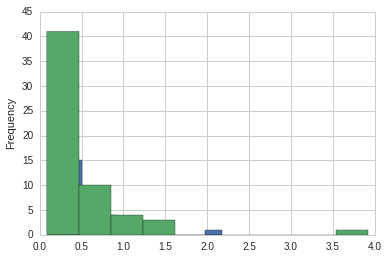

In [453]:
# motionInfo.head(10)
motionInfo.loc[(slice(None),'FEEDBACK'),:]['Max_Relative_RMS_Displacement'].plot(kind='hist')
motionInfo.loc[(slice(None),'NOFEEDBACK'),:]['Max_Relative_RMS_Displacement'].plot(kind='hist')

In [3]:
buttonPress=CCD_packages.getSubjectButtonResponses()

filename
CCD012    23
CCD014    22
CCD015    22
CCD016    22
CCD017    22
CCD018    22
CCD019    22
CCD020    22
CCD021    22
CCD022    22
CCD023    22
CCD024    22
CCD025    22
CCD026    22
CCD027    22
CCD031    22
CCD032    18
CCD033    19
CCD034     9
CCD040    21
CCD041    22
CCD042    19
CCD051    18
CCD052    16
CCD053    20
CCD059    21
CCD060    17
CCD061    22
CCD062    22
CCD063    20
CCD064    20
CCD065     4
CCD066    21
CCD067    16
CCD071    20
CCD072    19
CCD073    20
CCD074    21
CCD075     0
CCD076     6
CCD080     0
CCD081    16
CCD082    20
CCD083    21
CCD084    17
CCD085    22
CCD086     0
CCD087    20
CCD088    22
CCD089    16
CCD090    21
CCD091    20
CCD092    21
CCD093    20
CCD094    15
CCD095    20
CCD096    21
CCD097    19
CCD098    18
CCD099    21
Name: number, dtype: int64

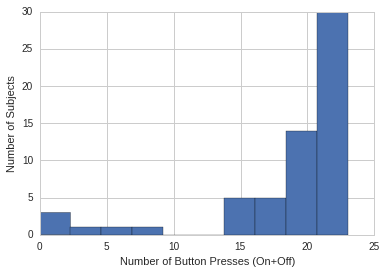

In [432]:
bp=buttonPress.groupby(['filename'])['number'].sum()
bp.plot(kind='hist')
plt.xlabel('Number of Button Presses (On+Off)')
plt.ylabel('Number of Subjects')
plt.savefig('%s/ButtonPresses.png' % CCD_packages.saveFigureLocation)

bp

In [5]:
# GroupDF.FB
GroupDF['fb']=GroupDF.FB=='FEEDBACK'

scanOrder=GroupDF.groupby(['Subject_ID','scanorder'])['fb'].mean()
fbNames=['NOFEEDBACK','FEEDBACK']
# 
fbNames[scanOrder.loc['CCD012',2]]

'NOFEEDBACK'

In [5]:
scanOrder

Subject_ID  scanorder
CCD012      1             True
            2            False
CCD014      1             True
            2            False
CCD015      1            False
            2             True
CCD016      1             True
            2            False
CCD017      1            False
            2             True
CCD018      1             True
            2            False
CCD019      1            False
            2             True
CCD020      1             True
            2            False
CCD021      1            False
            2             True
CCD022      1             True
            2            False
CCD023      1            False
            2             True
CCD024      1             True
            2            False
CCD025      1            False
            2             True
CCD026      1             True
            2            False
CCD027      1            False
            2             True
                         ...  
CCD085      1    

In [6]:
def runGLM(subj,out_dir,scanOrder):
    
    fbNames=['FEEDBACK','NOFEEDBACK']
    
    designFile='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/NFB+FB/motionRMS-1.000000-subjperf-15/cope1_age_gender/cope1_FWE_threshold_combined.nii.gz'

    for fb in [1,2]:
        designFile='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/dr_tempreg_maps_files_to_standard_smooth/_scan_tra/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/_fwhm_6/_dr_tempreg_maps_files_smooth_03/temp_reg_map_0003_antswarp_maths.nii.gz' % subj

#         fname='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global1.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % (subj,fb)
        fname='/home/jmuraskin/Projects/CCD/working_v1/feedback_run-%d/feedback/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/cope3.nii.gz' % (fb-1,subj)
        glm = fsl.GLM(in_file=fname, design=designFile, output_type='NIFTI',out_cope='%s/Focus_%s_%s.txt' % (out_dir,subj,fbNames[scanOrder.loc[subj,fb]]))

        glm.run()
        
        fname='/home/jmuraskin/Projects/CCD/working_v1/feedback_run-%d/feedback/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/cope4.nii.gz' % (fb-1,subj)
        glm = fsl.GLM(in_file=fname, design=designFile, output_type='NIFTI',out_cope='%s/Wander_%s_%s.txt' % (out_dir,subj,fbNames[scanOrder.loc[subj,fb]]))

        glm.run()



    
Parallel(n_jobs=10)(delayed(runGLM)(subj,out_dir,scanOrder) for subj in goodsubj)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [16]:
fb=1
subj='CCD012'
fname='/home/jmuraskin/Projects/CCD/working_v1/feedback_run-%d/feedback/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/cope3.nii.gz' % (fb-1,subj)
# fname='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global1.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % (subj,fb)

In [104]:
from nilearn.input_data import NiftiMapsMasker,NiftiMasker, NiftiSpheresMasker
# designFile='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/NFB+FB/motionRMS-1.000000-subjperf-15/cope1_age_gender/cope1_FWE_threshold_combined.nii.gz'
# designFile='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/NFB+FB/motionRMS-1.000000-subjperf-15/cope1_age_gender/cope1_FWE_threshold_tstat1.nii.gz'
# masker = NiftiMapsMasker(maps_img=designFile,memory='nilearn_cache', verbose=5)

# time_series = masker.fit_transform(fname)

In [ ]:
%pylab inline

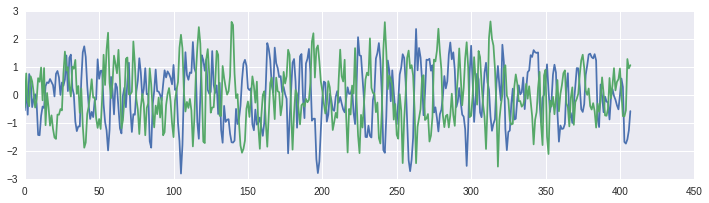

In [12]:
plt.figure(figsize=(12,3))
plt.plot(time_series)

In [92]:
from scipy.stats import pearsonr

In [65]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [350]:
import pandas as pd
roi_coords=[(42,21,-3)]
count=0
fbNames=['NOFEEDBACK','FEEDBACK']
fbNames_=['noFeedback','Feedback']
for subj in goodsubj:
    for fb in [1,2]:
        for cope in [3,4]:
            print "-----Running Subject %s with %s and cope %d-----" % (subj,fbNames[scanOrder.loc[subj,fb]],cope)
            designFile='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/dr_tempreg_maps_files_to_standard_smooth/_scan_tra/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/_fwhm_6/_dr_tempreg_maps_files_smooth_03/temp_reg_map_0003_antswarp_maths.nii.gz' % subj
            fname='/home/jmuraskin/Projects/CCD/working_v1/feedback_run-%d/feedback/_subject_id_%s/modelestimate/mapflow/_modelestimate0/results/zstat%d.nii.gz' % (fb-1,subj,cope)
            mean = '/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/mean_functional_in_mni/_scan_feedback_%d/fb_%d_calc_tshift_resample_volreg_calc_tstat_antswarp.nii.gz' %(subj,fb,fb)
            mask='/home/jmuraskin/Projects/CCD/working_v1/seg_probabilities/grey_matter_mask-20-percent.nii.gz'
            fwe = '/home/jmuraskin/Projects/CCD/working_v1/RSN/RSN0003-nonneg.nii.gz'
            r_ai_conn = '/home/jmuraskin/Projects/CCD/working_v1/seed-to-voxel/R_AI/%s/R_AI_%s.nii.gz' % (fbNames_[scanOrder.loc[subj,fb]],subj)
            
            masker = NiftiMasker(mask_img=mask, standardize=False,memory='nilearn_cache',memory_level=1)
            # # Extracting signal from sphere around DMN seeds
            s_masker = NiftiSpheresMasker(roi_coords, radius=8,
                                         detrend=False, standardize=False, 
                                         memory='nilearn_cache', 
                                         memory_level=1)
            # We give the masker a filename and retrieve a 2D array ready
            # for machine learning with scikit-learn
            fmri_masked = masker.fit_transform(fname)
            dmn_masked = masker.fit_transform(designFile)
            fwe_masked = masker.fit_transform(fwe)
            mean_masked = masker.fit_transform(mean)
            r_ai_conn_masked = masker.fit_transform(r_ai_conn)
            fwe_masked[fwe_masked<5]=0
            fwe_masked[fwe_masked!=0]=1
#             fwe_masked[fwe_masked!=1]=-1
            fmri_masked=fmri_masked[mean_masked>0]
            mean_masked2=mean_masked[mean_masked>0]
            
            r_ai_conn_data = np.mean(r_ai_conn_masked[fwe_masked==1])
            roi_masked = np.divide(np.mean(s_masker.fit_transform(fname))-np.mean(fmri_masked[mean_masked[mean_masked>0]>0]),np.mean(mean_masked[mean_masked>0]))*100
            roi_masked_nogsr = np.mean(np.divide(s_masker.fit_transform(fname),mean_masked[mean_masked>0]))*100

            #             roi_masked = np.divide(np.mean(s_masker.fit_transform(fname)),np.mean(s_masker.fit_transform(mean)))
#             roi= np.mean(np.divide(fmri_masked[fwe_masked[mean_masked>0]>0],mean_masked2[fwe_masked[mean_masked>0]>0]))-np.mean(np.divide(fmri_masked[fwe_masked[mean_masked>0]==0],mean_masked2[fwe_masked[mean_masked>0]==0]))
#             roi= np.mean(fmri_masked[fwe_masked[mean_masked>0]>0])-np.mean(fmri_masked[fwe_masked[mean_masked>0]==0])
            roi = np.dot(dmn_masked[mean_masked>0]-np.mean(dmn_masked[mean_masked>0]),fmri_masked-np.mean(fmri_masked))*1.0/(sum(mean_masked>0)-1)
#             roi=np.divide(m(fmri_masked,fwe_masked[mean_masked>0])-np.mean(fmri_masked[np.all([mean_masked[mean_masked>0]>0,fwe_masked[mean_masked>0]==0],axis=0)]),m(mean_masked[mean_masked>0],fwe_masked[mean_masked>0]))*100
            roi_nogsr=np.divide(m(fmri_masked,fwe_masked[mean_masked>0]),np.mean(mean_masked[mean_masked>0]))*100
            #             r,p = pearsonr(fmri_masked.T,dmn_masked.T)
#             corr_r = corr(fmri_masked.T,dmn_masked.T,fwe_masked.T)
            
            if count==0:
                df=pd.DataFrame({'Subject':subj, 'fb':fbNames[scanOrder.loc[subj,fb]],'cope':cope,'signal':roi,'roi':roi_masked,'signal_nogsr':roi_nogsr,'roi_nogsr':roi_masked_nogsr,'ai_dmn':r_ai_conn_data},index=[0])
            else:
                df=df.append(pd.DataFrame({'Subject':subj, 'fb':fbNames[scanOrder.loc[subj,fb]],'cope':cope,'signal':roi,'roi':roi_masked,'signal_nogsr':roi_nogsr,'roi_nogsr':roi_masked_nogsr,'ai_dmn':r_ai_conn_data},index=[0]),ignore_index=True)
            
            count+=1
            



-----Running Subject CCD012 with FEEDBACK and cope 3-----
-----Running Subject CCD012 with FEEDBACK and cope 4-----
-----Running Subject CCD012 with NOFEEDBACK and cope 3-----
-----Running Subject CCD012 with NOFEEDBACK and cope 4-----
-----Running Subject CCD014 with FEEDBACK and cope 3-----
-----Running Subject CCD014 with FEEDBACK and cope 4-----
-----Running Subject CCD014 with NOFEEDBACK and cope 3-----
-----Running Subject CCD014 with NOFEEDBACK and cope 4-----
-----Running Subject CCD015 with NOFEEDBACK and cope 3-----
-----Running Subject CCD015 with NOFEEDBACK and cope 4-----
-----Running Subject CCD015 with FEEDBACK and cope 3-----
-----Running Subject CCD015 with FEEDBACK and cope 4-----
-----Running Subject CCD016 with FEEDBACK and cope 3-----
-----Running Subject CCD016 with FEEDBACK and cope 4-----
-----Running Subject CCD016 with NOFEEDBACK and cope 3-----
-----Running Subject CCD016 with NOFEEDBACK and cope 4-----
-----Running Subject CCD017 with NOFEEDBACK and cope 3--

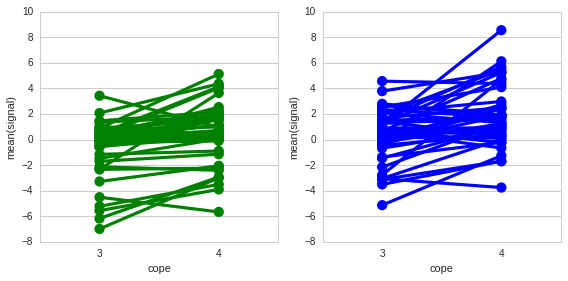

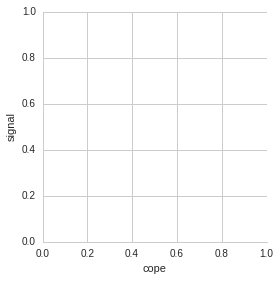

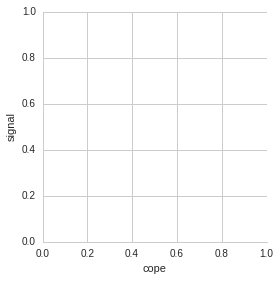

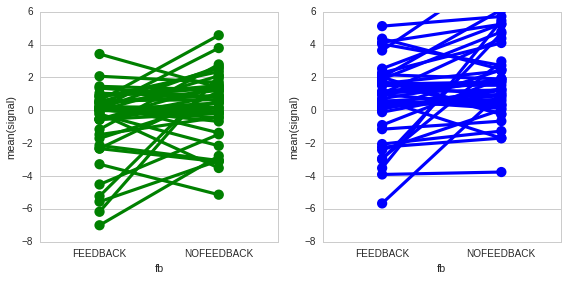

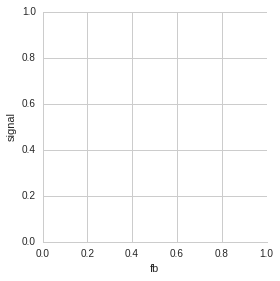

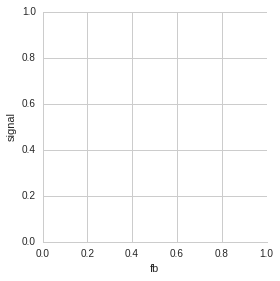

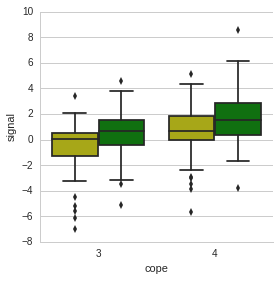

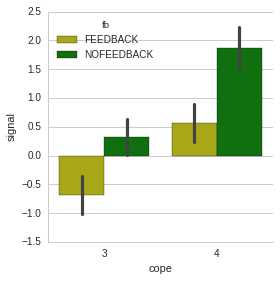

In [343]:
import seaborn as sns
f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4));
sns.factorplot(x='cope',y='signal',hue='Subject',data=df[df.fb=='FEEDBACK'],kind='point',ax=ax1,ci=68,palette=['g'],legend=False,legend_out=False);

sns.factorplot(x='cope',y='signal',hue='Subject',data=df[df.fb=='NOFEEDBACK'],kind='point',ax=ax2,ci=68,palette=['b'],legend=False,legend_out=False);
ax1.set_ylim(ax2.get_ylim());

ax2.legend_.remove();
ax1.legend_.remove();
f.tight_layout();



f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4));
sns.factorplot(x='fb',y='signal',hue='Subject',data=df[df.cope==3],kind='point',ax=ax1,ci=68,palette=['g'],legend=False,legend_out=False);

sns.factorplot(x='fb',y='signal',hue='Subject',data=df[df.cope==4],kind='point',ax=ax2,ci=68,palette=['b'],legend=False,legend_out=False);
ax2.set_ylim(ax1.get_ylim());

ax2.legend_.remove();
ax1.legend_.remove();
f.tight_layout();




sns.factorplot(x='cope',y='signal',hue='fb',data=df,units='Subject',kind='box',ci=68,palette=['y','g'],legend=False,legend_out=False);


sns.factorplot(x='cope',y='signal',hue='fb',data=df,units='Subject',kind='bar',ci=68,palette=['y','g'],legend=True,legend_out=False);

# sns.factorplot(x='fb',y='signal',hue='Subject',data=df[df.cope==4],kind='point',ax=ax2,ci=68,palette=['b'],legend=False,legend_out=False);
# ax2.set_ylim(ax1.get_ylim())

# ax2.legend_.remove()
# ax1.legend_.remove()
# f.tight_layout()
# ax1.set_xticklabels(['Focus','Wander'],fontsize=12)
# ax1.set_xlabel('')
# ax1.set_title('DMN Activation',fontsize=14)

# ax1.set_ylabel('Percent Acitivation (%)',fontsize=12)

# sns.factorplot(x='cope',y='roi',hue='fb',data=df,units='Subject',kind='bar',ci=68,palette=['g','b'],ax=ax2);
# ax2.set_xticklabels(['Focus','Wander'],fontsize=12)
# ax2.set_xlabel('')
# ax2.set_title('Insula Activation',fontsize=14)
# ax2.legend_.remove()

# ax2.set_ylabel('Percent Acitivation (%)',fontsize=12)
# f.tight_layout()

# f.savefig('%s/GM_mean_removed_DMN_IA_activation.png' % CCD_packages.saveFigureLocation,dpi=300)


In [330]:
t_wander,p_wander = ttest_1samp(df[np.all([df.fb=='FEEDBACK',df.cope==4],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==4],axis=0)]['signal'].values,0)
t_focus,p_focus = ttest_1samp(df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values,0)

print p_wander
print p_focus


t_fb,p_fb = ttest_1samp(df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='FEEDBACK',df.cope==4],axis=0)]['signal'].values,0)
t_nfb,p_nfb = ttest_1samp(df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==4],axis=0)]['signal'].values,0)

print p_fb
print p_nfb

0.00158016543044
0.00678471392013
3.93874232846e-06
4.06628285948e-05


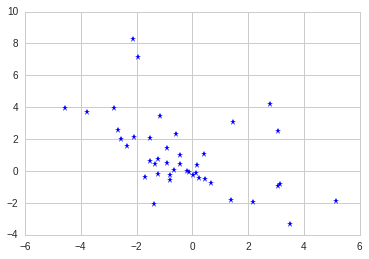

In [331]:
plt.plot(-1*df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values,-1*(df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values),'b*')

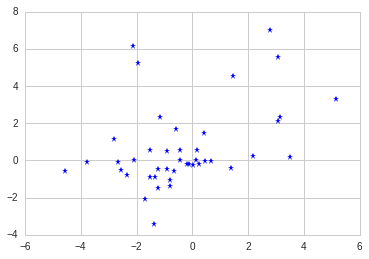

In [332]:
plt.plot(-1*df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values,-1*(df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values),'b*')

In [352]:
df.head(10)
# f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
# sns.factorplot(x='cope',y='signal_nogsr',hue='fb',data=df,units='Subject',kind='bar',ci=68,palette=['g','b'],ax=ax1);
# ax1.set_xticklabels(['Focus','Wander'],fontsize=12)
# ax1.set_xlabel('')
# ax1.set_title('DMN Activation',fontsize=14)

# ax1.set_ylabel('Percent Acitivation (%)',fontsize=12)

# sns.factorplot(x='cope',y='roi_nogsr',hue='fb',data=df,units='Subject',kind='bar',ci=68,palette=['g','b'],ax=ax2);
# ax2.set_xticklabels(['Focus','Wander'],fontsize=12)
# ax2.set_xlabel('')
# ax2.set_title('Insula Activation',fontsize=14)
# ax2.legend_.remove()

# ax2.set_ylabel('Percent Acitivation (%)',fontsize=12)
# f.tight_layout()

# f.savefig('%s/DMN_IA_activation.png' % CCD_packages.saveFigureLocation,dpi=300)

,Subject,ai_dmn,cope,fb,roi,roi_nogsr,signal,signal_nogsr
0,CCD012,0.509151,3,FEEDBACK,-0.156102,-1.420806,-0.237543,-0.069753
1,CCD012,0.509151,4,FEEDBACK,-0.142337,-1.001727,-0.110110,-0.005078
2,CCD012,-2.486749,3,NOFEEDBACK,0.101281,-0.340435,-2.159871,-0.211007
3,CCD012,-2.486749,4,NOFEEDBACK,-0.084473,-1.344276,1.231875,-0.026645
4,CCD014,3.415483,3,FEEDBACK,0.017315,-3.129687,-2.327892,-0.342799
5,CCD014,3.415483,4,FEEDBACK,-0.029326,-2.945644,3.639404,-0.047155
6,CCD014,3.420403,3,NOFEEDBACK,-0.271907,-9.924757,1.144441,-0.344874
7,CCD014,3.420403,4,NOFEEDBACK,-0.481239,-13.920322,8.554348,-0.117034
8,CCD015,2.111824,3,NOFEEDBACK,-0.172307,-1.730718,1.952070,-0.126195
9,CCD015,2.111824,4,NOFEEDBACK,-0.231524,-2.219226,5.450425,-0.045625


In [283]:
ax2.get_ylim()

(-1000000.0, 800000.0)

-0.300810590694
0.0499859432518


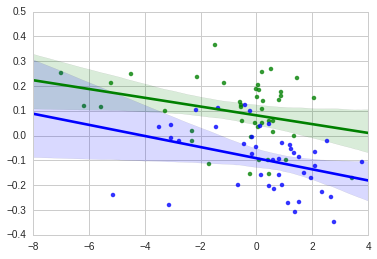

In [383]:
sns.regplot(y=df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['roi'].values,x=df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['signal'].values,color='g')
sns.regplot(y=df[np.all([df['fb']=='NOFEEDBACK',df['cope']==3],axis=0)]['roi'].values,x=df[np.all([df['fb']=='NOFEEDBACK',df['cope']==3],axis=0)]['signal'].values,color='b')


r,p = pearsonr(df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['roi'].values,df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['signal'].values)
print r
print p

In [162]:
import statsmodels.api as sm
import matplotlib.lines as mlines


# phenoValuesTotal=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
# phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
# fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

# sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

pheno=pd.read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)
subject_list=goodsubj

addmotion=True
addNOFB=False
addScanOrder=False
# addWander=True



phenoValues=['V1_DEM_001','V1_DEM_002']


# modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
if addmotion:

    pheno=pheno.loc[subject_list][phenoValues]
    phenoValues+=['meanFD']
    if fb:
        pheno['meanFD'] = motionInfo
        pheno['Insula'] = df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['ai_dmn'].values
    else:
        pheno['meanFD']=motionInfoNFB
        pheno['Insula'] = df[np.all([df['fb']=='NOFEEDBACK',df['cope']==3],axis=0)]['ai_dmn'].values

#             modelX=pheno

else:
    pheno=pheno.loc[subject_list][phenoValues]

# if addNOFB:
#     phenoValues+=['NOFB']
#     modelX['NOFB']=NOFB

# if addScanOrder:
#     phenoValues+=['scanorder']
#     pheno['scanorder']=scanorder

# if addWander:
#     if fb:
#         pheno['Wander']=fw_spatial.loc[goodsubj,[4],'FEEDBACK'].values
#     else:
#         pheno['Wander']=fw_spatial.loc[goodsubj,[4],'NOFEEDBACK'].values


if fb:
    inputs=df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['signal'].values
else:
    inputs=df[np.all([df['fb']=='NOFEEDBACK',df['cope']==3],axis=0)]['signal'].values

    
modelX=pheno

results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=False,plotFigure=False)

print results.summary()

# sm.graphics.plot_ccpr(results, phenoV, ax=ax)
# sns.set_style("whitegrid")
# print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])





# ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')



# title=phenoName 
# title+= '*' if results.pvalues[phenoV]<0.05 else ''

# ax.set_title(title,fontsize=16)

# ax.set_xlabel('')
# if phenoName=='AIM':
# ax.set_ylabel('Focus Residuals',fontsize=16)
# else:
# ax.set_ylabel('')
# #     ax.set_title('')
# for tick in ax.get_xticklabels():
# tick.set_rotation(45)

# if phenoName=='PANAS':
# blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
# green_line = mlines.Line2D([], [], color='green', label='Feedack On')
# plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
# #         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
# #     handles, labels = ax.get_legend_handles_labels()
# #        

# #     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
# fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.07,right=.86)
# fig.savefig('%s/Focus_Spatial_Total_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.216
Date:                Wed, 18 Jan 2017   Prob (F-statistic):             0.0855
Time:                        11:31:18   Log-Likelihood:                -71.969
No. Observations:                  43   AIC:                             153.9
Df Residuals:                      38   BIC:                             162.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -3.4832      1.105     -3.153      0.0

In [358]:
df.to_csv('Focus-Wander-SpatialROI.csv')

In [7]:
import seaborn as sns

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



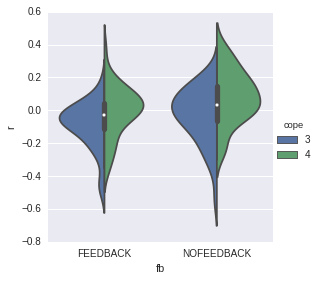

In [18]:
sns.factorplot(x='fb',y='r',hue='cope',data=df,units='Subject',kind='violin',split=True)

In [265]:
plt.figure()
sns.set_style("whitegrid")
# sns.pointplot
g=sns.factorplot(x='cope',y='r',hue='fb',data=df,units='Subject',kind='violin',split=True,inner='stick',palette=['g','b'])
g.set_xticklabels(['Focus','Wander'])
g.set_xlabels('')
g.set_ylabels('Spatial Correlation to DMN Template (r)')

# g.savefig('%s/DMN_SpatialCorrelaion.png' % CCD_packages.saveFigureLocation,dpi=300)


plt.figure()
sns.set_style("whitegrid")
# sns.pointplot
g=sns.pointplot(x='fb',y='r',hue='cope',data=df,units='Subject',palette=['g','b'])
# g.set_xticklabels(['Focus','Wander'])
# g.set_xlabels('')
plt.ylabel('Spatial Correlation to DMN Template (r)')

# plt.savefig('%s/DMN_Pointplot.png' % CCD_packages.saveFigureLocation,dpi=300)


plt.figure()
g=sns.factorplot(x='cope',y='w_r',hue='fb',data=df,units='Subject',kind='bar',ci=68,palette=['g','b'])
g.set_xticklabels(['Focus','Wander'],fontsize=12)
g.set_xlabels('')
plt.title('Spatial Correlation to DMN',fontsize=14)

g.set_ylabels('Spatial Correlation (r)',fontsize=12)
# g.savefig('%s/DMN_Weighted_Spatial_Correlation.png' % CCD_packages.saveFigureLocation,dpi=300)

ValueError: Could not interpret input 'r'

In [74]:
from scipy.stats import ttest_1samp

In [359]:
t_wander,p_wander = ttest_1samp(df[np.all([df.fb=='FEEDBACK',df.cope==4],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==4],axis=0)]['signal'].values,0)
t_focus,p_focus = ttest_1samp(df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values,0)

print p_wander
print p_focus


t_fb,p_fb = ttest_1samp(df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='FEEDBACK',df.cope==4],axis=0)]['signal'].values,0)
t_nfb,p_nfb = ttest_1samp(df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==4],axis=0)]['signal'].values,0)

print p_fb
print p_nfb

0.00158016543044
0.00678471392013
3.93874232846e-06
4.06628285948e-05


0.885692714666
0.893906326626


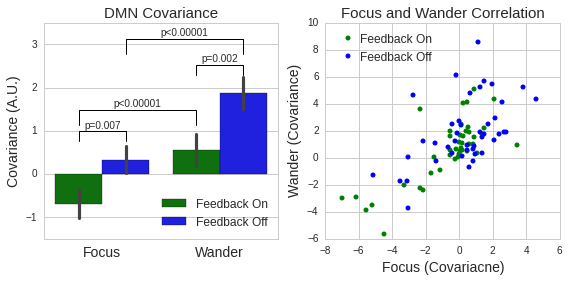

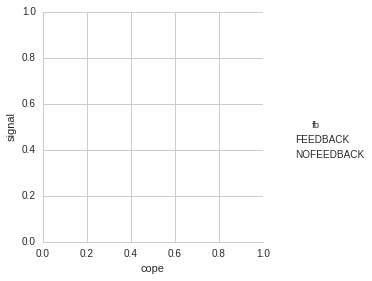

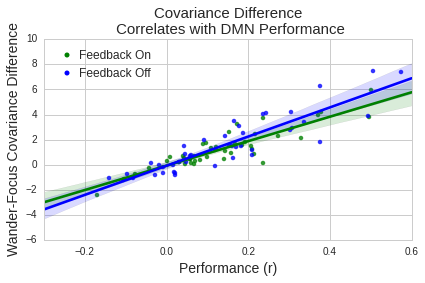

In [454]:
def label_diff(ax,i,j,text,X,Y,shrink=5,yshift=.2):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':shrink,'shrinkB':shrink,'lw':1}
    ax.annotate(text, xy=(x,y + yshift), zorder=10,ha='center')
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)


f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
sns.factorplot(x='cope',y='signal',hue='fb',data=df,units='Subject',kind='bar',ci=68,palette=['g','b'],ax=ax1,figure=f)
ax1.set_xticklabels(['Focus','Wander'],fontsize=14)
ax1.set_xlabel('')
# ax1.set_title('Correlation to DMN',fontsize=16)
ax1.legend_.remove()
# ax1.set_ylabel('Spatial Correlation (r)',fontsize=14)
ax1.set_ylim([-1.5,3.5])
ax1.set_title('DMN Covariance',fontsize=15)

ax1.set_ylabel('Covariance (A.U.)',fontsize=14)

X=[-0.2,.2,.8,1.2]
menMeans=[-.1,.01,.3,1.1]

label_diff(ax1,0,1,'p=%0.3f' % p_focus,X,[-.1,.6,.7,1.5],shrink=4,yshift=.4)
label_diff(ax1,0,2,'p<0.00001',X,[-.1,.5,.6,1.5],shrink=20,yshift=.9)
label_diff(ax1,1,3,'p<0.00001' ,X,[-.1,.5,.7,2.1],shrink=20,yshift=.9)
label_diff(ax1,2,3,'p=%0.3f' % p_wander,X,[-.1,.5,.7,2],shrink=4,yshift=.4)
# label_diff(1,2,'p<0.0001',X,menMeans)
# label_diff(2,3,'p=0.0025',X,menMeans)
# ax1.legend(False)
# ax1.savefig('%s/DMN_Weighted_Spatial_Correlation.png' % CCD_packages.saveFigureLocation,dpi=300)

ax2.plot(df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'],df[np.all([df.fb=='FEEDBACK',df.cope==4],axis=0)]['signal'],'go',markersize=5,label='Feedback On')
ax2.plot(df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'],df[np.all([df.fb=='NOFEEDBACK',df.cope==4],axis=0)]['signal'],'bo',markersize=5,label='Feedback Off')
ax2.set_xlabel('Focus (Covariacne)',fontsize=14)
ax2.set_ylabel('Wander (Covariance)',fontsize=14)
ax2.set_title('Focus and Wander Correlation',fontsize=15)
ax2.legend(loc=2,fontsize=12,handletextpad=0)
# ax1.set_title('Sorted Subject Performance',fontsize=18)
handles, labels = ax1.get_legend_handles_labels()
labels[0]='Feedback On'
labels[1]='Feedback Off'
ax1.legend(handles,labels,ncol=1,loc=4,fontsize=12)


f_new,ax3 = plt.subplots(1,1)
SubjectDF = GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB','TR'])['RSN3','flip','modelcorr'].mean()

sns.regplot(y=df[np.all([df['fb']=='FEEDBACK',df['cope']==4],axis=0)]['signal'].values-df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['signal'].values,x=SubjectDF.loc[goodsubj,'FEEDBACK',[0]]['modelcorr'].values,ax=ax3,color='g')
sns.regplot(y=df[np.all([df['fb']=='NOFEEDBACK',df['cope']==4],axis=0)]['signal'].values-df[np.all([df['fb']=='NOFEEDBACK',df['cope']==3],axis=0)]['signal'].values,x=SubjectDF.loc[goodsubj,'NOFEEDBACK',[0]]['modelcorr'].values,ax=ax3,color='b')

r,p=pearsonr(df[np.all([df['fb']=='FEEDBACK',df['cope']==4],axis=0)]['signal'].values-df[np.all([df['fb']=='FEEDBACK',df['cope']==3],axis=0)]['signal'].values,SubjectDF.loc[goodsubj,'FEEDBACK',[0]]['modelcorr'].values)
print r
r,p=pearsonr(df[np.all([df['fb']=='NOFEEDBACK',df['cope']==4],axis=0)]['signal'].values-df[np.all([df['fb']=='NOFEEDBACK',df['cope']==3],axis=0)]['signal'].values,SubjectDF.loc[goodsubj,'NOFEEDBACK',[0]]['modelcorr'].values)
print r
ax3.set_xlabel('Performance (r)',fontsize=14)
ax3.set_ylabel('Wander-Focus Covariance Difference',fontsize=14)
ax3.set_title('Covariance Difference \n Correlates with DMN Performance',fontsize=15)
handles, labels = ax2.get_legend_handles_labels()
ax3.legend(handles,labels,ncol=1,loc=2,fontsize=12,handletextpad=0)
f_new.tight_layout()
f.tight_layout()
f.savefig('%s/DMN_Covariance_Modulation.png' % CCD_packages.saveFigureLocation,dpi=300)
f_new.savefig('%s/DMN_Covariance_Modulation_vs_DR_DMN_TC.png' % CCD_packages.saveFigureLocation,dpi=300)

-0.556931440652


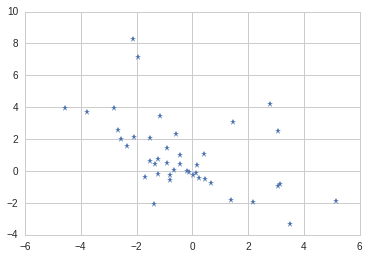

In [431]:
plt.plot(-1*df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'],df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values,'*')


r_help,p_help = spearmanr(df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'],df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values)
print r_help

-0.532920567804


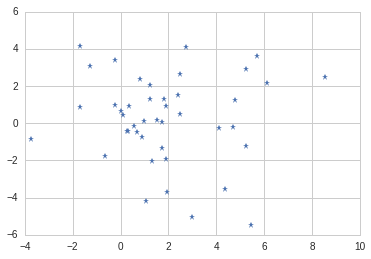

In [430]:
plt.plot(df[np.all([df.fb=='NOFEEDBACK',df.cope==4],axis=0)]['signal'],df[np.all([df.fb=='FEEDBACK',df.cope==4],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values,'*')


r_help,p_help = spearmanr(df[np.all([df.fb=='NOFEEDBACK',df.cope==4],axis=0)]['signal'],df[np.all([df.fb=='FEEDBACK',df.cope==3],axis=0)]['signal'].values-df[np.all([df.fb=='NOFEEDBACK',df.cope==3],axis=0)]['signal'].values)
print r_help

In [381]:



focus_and_wander=np.intersect1d(df[np.all([df.fb=='FEEDBACK',df.cope==3,df.signal<0],axis=0)]['Subject'],df[np.all([df.fb=='FEEDBACK',df.cope==4,df.signal>0],axis=0)]['Subject'])
focus_only=np.intersect1d(df[np.all([df.fb=='FEEDBACK',df.cope==3,df.signal<0],axis=0)]['Subject'],df[np.all([df.fb=='FEEDBACK',df.cope==4,df.signal<0],axis=0)]['Subject'])
wander_only=np.intersect1d(df[np.all([df.fb=='FEEDBACK',df.cope==3,df.signal>0],axis=0)]['Subject'],df[np.all([df.fb=='FEEDBACK',df.cope==4,df.signal>0],axis=0)]['Subject'])

print len(focus_and_wander)
print len(focus_only)
print len(wander_only)

subjectList = np.unique(df['Subject'])
tempZeros=np.zeros(len(subjectList),)
tempZeros[np.in1d(subjectList,wander_only)]=1


9
11
23
[ 0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.
  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.
  1.  0.  1.  1.  1.  1.  0.]


In [382]:
wander_only

array(['CCD019', 'CCD021', 'CCD024', 'CCD025', 'CCD027', 'CCD031',
       'CCD032', 'CCD042', 'CCD052', 'CCD059', 'CCD063', 'CCD064',
       'CCD071', 'CCD074', 'CCD081', 'CCD084', 'CCD088', 'CCD089',
       'CCD090', 'CCD092', 'CCD094', 'CCD095', 'CCD097'], dtype=object)

In [384]:
goodfocus=df[np.all([df.cope==3,df.fb=='FEEDBACK',df.signal<0],axis=0)].Subject
badfocus=df[np.all([df.cope==3,df.fb=='FEEDBACK',df.signal>0],axis=0)].Subject
goodwander=df[np.all([df.cope==4,df.fb=='FEEDBACK',df.signal>0],axis=0)].Subject
badwander=df[np.all([df.cope==4,df.fb=='FEEDBACK',df.signal<0],axis=0)].Subject

In [385]:
goodf_goodw = np.intersect1d(goodfocus,goodwander)
goodf_badw = np.intersect1d(goodfocus,badwander)
badf_goodw = np.intersect1d(badfocus,goodwander)

In [386]:
print goodf_goodw.size
print goodf_badw.size
print badf_goodw.size

9
11
23


V1_DEM_001:  F-Value= 1.41 p-Value= 0.2565
V1_DEM_002:  F-Value= 1.52 p-Value= 0.2319
V1_CCDAIM_41:  F-Value= 1.61 p-Value= 0.2122
V1_CCDSIPI_49:  F-Value= 0.70 p-Value= 0.5003
V1_CCDERQ_13:  F-Value= 0.35 p-Value= 0.7102
V1_DBDI_22:  F-Value= 1.04 p-Value= 0.3640
V1_CCDRSQ_72:  F-Value= 0.07 p-Value= 0.9319
V1_CCDPANAS_23:  F-Value= 0.01 p-Value= 0.9895
V1_CCDAIM_42:  F-Value= 0.11 p-Value= 0.8960
V1_CCDAIM_43:  F-Value= 0.82 p-Value= 0.4458
V1_CCDAIM_44:  F-Value= 0.72 p-Value= 0.4953
V1_CCDAIM_45:  F-Value= 3.13 p-Value= 0.0544
V1_CCDSIPI_46:  F-Value= 1.33 p-Value= 0.2758
V1_CCDSIPI_47:  F-Value= 1.00 p-Value= 0.3766
V1_CCDSIPI_48:  F-Value= 1.01 p-Value= 0.3725
V1_CCDRSQ_73:  F-Value= 0.78 p-Value= 0.4670
V1_CCDRSQ_74:  F-Value= 0.11 p-Value= 0.8937
V1_CCDRSQ_75:  F-Value= 2.20 p-Value= 0.1241
V1_CCDPANAS_21:  F-Value= 0.55 p-Value= 0.5802
V1_CCDPANAS_22:  F-Value= 0.97 p-Value= 0.3860
V1_CCDERQ_11:  F-Value= 0.07 p-Value= 0.9347
V1_CCDERQ_12:  F-Value= 0.97 p-Value= 0.3883


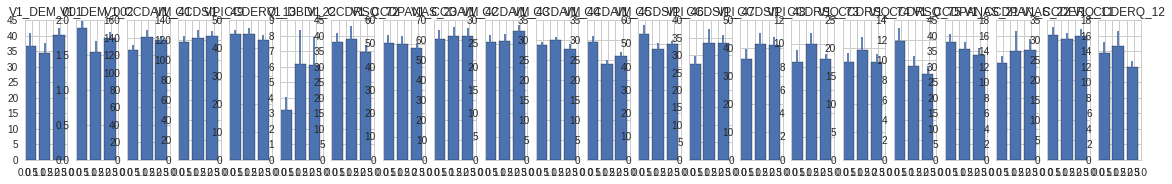

In [422]:
import statsmodels.formula.api as sm
import matplotlib.lines as mlines
import scipy.stats as stats


phenoValuesTotal=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23','V1_CCDAIM_42','V1_CCDAIM_43','V1_CCDAIM_44','V1_CCDAIM_45','V1_CCDSIPI_46','V1_CCDSIPI_47','V1_CCDSIPI_48','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75','V1_CCDPANAS_21','V1_CCDPANAS_22','V1_CCDERQ_11','V1_CCDERQ_12']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
fig, axes = plt.subplots(1,len(phenoValuesTotal),figsize=(20, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


pheno=pd.read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)



for phenoV,ax in zip(phenoValuesTotal,axes):
    
    means = [pheno.loc[goodf_goodw][phenoV].mean(),pheno.loc[goodf_badw][phenoV].mean(),pheno.loc[badf_goodw][phenoV].mean()]
    ste = [pheno.loc[goodf_goodw][phenoV].std()/np.sqrt(goodf_goodw.size),pheno.loc[goodf_badw][phenoV].std()/np.sqrt(goodf_badw.size),pheno.loc[badf_goodw][phenoV].std()/np.sqrt(badf_goodw.size)]
    
    
    
    ax.bar(range(3),means,yerr=ste)
    ax.set_title(phenoV)
    
    phenoTemp = pheno.copy()
    
    results=sm.ols('%s ~ V1_DEM_001 + V1_DEM_002' % phenoV, data = phenoTemp).fit()
    
    phenoTemp[phenoV] = results.resid

    
    f,p = stats.f_oneway(phenoTemp.loc[goodf_goodw][phenoV],phenoTemp.loc[goodf_badw][phenoV],phenoTemp.loc[badf_goodw][phenoV])
    print '%s:  F-Value= %0.2f p-Value= %0.4f' % (phenoV,f,p)
    
# fig.tight_layout()

In [156]:
performance=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB'])['modelcorr'].mean()

In [410]:
url = 'http://vincentarelbundock.github.io/Rdatasets/csv/HistData/Guerry.csv'
dat = pd.read_csv(url)
results = sm.ols('Lottery ~ Literacy + np.log(Pop1831)', data=dat).fit()


                            OLS Regression Results                            
Dep. Variable:           V1_CCDERQ_12   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.334
Date:                Wed, 08 Mar 2017   Prob (F-statistic):              0.272
Time:                        16:48:50   Log-Likelihood:                -178.85
No. Observations:                  60   AIC:                             363.7
Df Residuals:                      57   BIC:                             370.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     18.7532      3.298      5.686      0.0

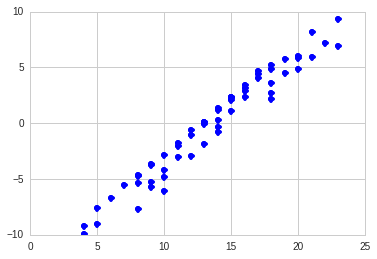

In [417]:
phenoNew = pheno.reset_index(level=0, inplace=False)
# phenoNew
results=sm.ols('V1_CCDERQ_12 ~ V1_DEM_001 + V1_DEM_002', data = pheno).fit()
print(results.summary())
plt.plot(phenoNew['V1_CCDERQ_12'],results.resid,'bo')

In [399]:
! pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org -U statsmodels

    100% |████████████████████████████████| 6.2MB 7.1MB/s 
Requirement already up-to-date: scipy in /home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages (from statsmodels)
Requirement already up-to-date: patsy in /home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages (from statsmodels)
    100% |████████████████████████████████| 17.2MB 26.8MB/s 
Requirement already up-to-date: numpy in /home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages (from patsy->statsmodels)
Requirement already up-to-date: six in /home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages (from patsy->statsmodels)
Requirement already up-to-date: pytz>=2011k in /home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages (from pandas->statsmodels)
Requirement already up-to-date: python-dateutil in /home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages (from pandas->statsmodels)
  Found existing installation: pandas 0.18.1
    Uninstalling pandas-0.18.

In [168]:
Z=[]
for subj in goodsubj:
    Z.append((zperformance.loc[subj,'FEEDBACK']-zperformance.loc[subj,'NOFEEDBACK'])/np.sqrt(1/405.0+1/405.0))

In [192]:
goodsubj[np.all([np.array(Z)>1.64],axis=0)]

array(['CCD019', 'CCD023', 'CCD041', 'CCD042', 'CCD067', 'CCD088',
       'CCD092', 'CCD099'], dtype=object)

In [191]:
goodsubj[np.all([np.array(Z)<-1.64],axis=0)]

array(['CCD012', 'CCD020', 'CCD021', 'CCD031', 'CCD040', 'CCD053',
       'CCD060', 'CCD073', 'CCD085'], dtype=object)

V1_DEM_001:  F-Value= 0.00 p-Value= 0.9613
V1_DEM_002:  F-Value= 0.38 p-Value= 0.5517
V1_CCDAIM_41:  F-Value= 1.27 p-Value= 0.2813
V1_CCDSIPI_49:  F-Value= 0.56 p-Value= 0.4678
V1_CCDERQ_13:  F-Value= 0.00 p-Value= 0.9695
V1_DBDI_22:  F-Value= 3.72 p-Value= 0.0777
V1_CCDRSQ_72:  F-Value= 0.31 p-Value= 0.5861
V1_CCDPANAS_23:  F-Value= 0.04 p-Value= 0.8433
V1_CCDAIM_42:  F-Value= 1.43 p-Value= 0.2552
V1_CCDAIM_43:  F-Value= 0.11 p-Value= 0.7426
V1_CCDAIM_44:  F-Value= 0.64 p-Value= 0.4406
V1_CCDAIM_45:  F-Value= 1.35 p-Value= 0.2687
V1_CCDSIPI_46:  F-Value= 0.12 p-Value= 0.7324
V1_CCDSIPI_47:  F-Value= 0.51 p-Value= 0.4904
V1_CCDSIPI_48:  F-Value= 0.31 p-Value= 0.5909
V1_CCDRSQ_73:  F-Value= 0.31 p-Value= 0.5895
V1_CCDRSQ_74:  F-Value= 0.47 p-Value= 0.5060
V1_CCDRSQ_75:  F-Value= 0.00 p-Value= 0.9539
V1_CCDPANAS_21:  F-Value= 0.73 p-Value= 0.4095
V1_CCDPANAS_22:  F-Value= 0.80 p-Value= 0.3889
V1_CCDERQ_11:  F-Value= 0.27 p-Value= 0.6149
V1_CCDERQ_12:  F-Value= 0.38 p-Value= 0.5500


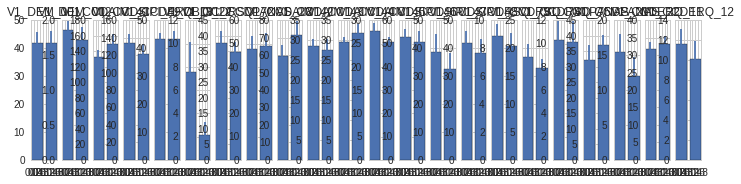

In [190]:
import statsmodels.api as sm
import matplotlib.lines as mlines
import scipy.stats as stats


phenoValuesTotal=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23','V1_CCDAIM_42','V1_CCDAIM_43','V1_CCDAIM_44','V1_CCDAIM_45','V1_CCDSIPI_46','V1_CCDSIPI_47','V1_CCDSIPI_48','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75','V1_CCDPANAS_21','V1_CCDPANAS_22','V1_CCDERQ_11','V1_CCDERQ_12']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
fig, axes = plt.subplots(1,len(phenoValuesTotal),figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


pheno=pd.read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)

for phenoV,ax in zip(phenoValuesTotal,axes):
    
    means = [pheno.loc[goodsubj[np.all([np.array(Z)>1.96],axis=0)]][phenoV].mean(),pheno.loc[goodsubj[np.all([np.array(Z)<-1.96],axis=0)]][phenoV].mean()]
    ste = [pheno.loc[goodsubj[np.all([np.array(Z)>1.96],axis=0)]][phenoV].std()/np.sqrt(goodsubj[np.all([np.array(Z)>1.96],axis=0)].size),
                     pheno.loc[goodsubj[np.all([np.array(Z)<-1.96],axis=0)]][phenoV].std()/np.sqrt(goodsubj[np.all([np.array(Z)<-1.96],axis=0)].size)]
           
    ax.bar(range(2),means,yerr=ste)
    ax.set_title(phenoV)
    
    f,p = stats.f_oneway(pheno.loc[goodsubj[np.all([np.array(Z)>1.96],axis=0)]][phenoV],pheno.loc[goodsubj[np.all([np.array(Z)<-1.96],axis=0)]][phenoV])
    print '%s:  F-Value= %0.2f p-Value= %0.4f' % (phenoV,f,p)

In [183]:
# score = score - currentSign*arrow_scale*score_factor
# score_factor = 90.0 / (30.0*0.5)
# if score < 0:
#                     score = 0
#                 elif score > 180:
#                     score = 180

[11.571428571428571, 10.142857142857142]

In [415]:
from scipy.stats import zscore
# np.int(GroupDF[np.all([GroupDF.Subject_ID==subj,GroupDF.FB=='FEEDBACK'],axis=0)]['scanorder'].mean())
if not os.path.exists('../../working_v1/FB_Signal'):
    os.mkdir('../../working_v1/FB_Signal')

for subj in goodsubj:
    for run in range(1,3):
        filename='../../NARSAD-DMN-clean/%s_run%d.txt' % (subj,run)

        config=pd.read_table(filename,delimiter=';',comment='#')

        score=[]
        timeStamp=[]
        logDF=config[np.any([config[' Stim Text']==' Focus',config[' Stim Text']==' Wander',config[' Stim Text']==' Rest',config[' Stim Text']==' Push Button'],axis=0)]
        cs,sign=get_cumulative_score(logDF)
        logDF[' Cumulative Score'] = cs
        logDF[' Sign'] = sign

        rows,columns=logDF.shape
        for row in range(rows):
            timeStamp.append(np.float(logDF['Time Stamp'].iloc[row]))
            if logDF[' Stim Text'].iloc[row]==' Wander':
                if logDF[' Sign'].iloc[row]==1:
                    score.append(90.0-logDF[' Cumulative Score'].iloc[row])
                elif logDF[' Sign'].iloc[row]==-1:
                    score.append(logDF[' Cumulative Score'].iloc[row]-90.0)
            elif logDF[' Stim Text'].iloc[row]==' Focus':
                if logDF[' Sign'].iloc[row]==1:
                    score.append(logDF[' Cumulative Score'].iloc[row]-90.0)
                elif logDF[' Sign'].iloc[row]==-1:
                    score.append(90.0-logDF[' Cumulative Score'].iloc[row])
            else:
                score.append(0)

        timeStamp=np.array(timeStamp)-8.0
        score=np.array(score)/90.0
        if len(score) > 410:
            timeStamp= np.delete(timeStamp,-1)
            score = np.delete(score,-1)
            print subj
        tmpdf=pd.DataFrame({'timeStamp':timeStamp[2:],'score':score[2:]})
        tmpdf.to_csv('../../working_v1/FB_Signal/%s_run%d.csv' % (subj,run),index=False)
#         plt.plot(timeStamp,np.array(score)/90.0)

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CCD012
CCD012
CCD017
CCD027
CCD040
CCD040
CCD041
CCD042
CCD042
CCD052
CCD060
CCD060
CCD063
CCD063
CCD071
CCD073
CCD074
CCD082
CCD084
CCD089
CCD091
CCD091
CCD092
CCD092
CCD094
CCD094
CCD097


In [414]:
subj='CCD012'
run=2

filename='../../NARSAD-DMN-clean/%s_run%d.txt' % (subj,run)

config=pd.read_table(filename,delimiter=';',comment='#')

score=[]
timeStamp=[]
logDF=config[np.any([config[' Stim Text']==' Focus',config[' Stim Text']==' Wander',config[' Stim Text']==' Rest',config[' Stim Text']==' Push Button'],axis=0)]
cs,sign=get_cumulative_score(logDF)
logDF[' Cumulative Score'] = cs
logDF[' Sign'] = sign

rows,columns=logDF.shape
for row in range(rows):
    timeStamp.append(np.float(logDF['Time Stamp'].iloc[row]))
    if logDF[' Stim Text'].iloc[row]==' Wander':
        if logDF[' Sign'].iloc[row]==1:
            score.append(90.0-logDF[' Cumulative Score'].iloc[row])
        elif logDF[' Sign'].iloc[row]==-1:
            score.append(logDF[' Cumulative Score'].iloc[row]-90.0)
    elif logDF[' Stim Text'].iloc[row]==' Focus':
        if logDF[' Sign'].iloc[row]==1:
            score.append(logDF[' Cumulative Score'].iloc[row]-90.0)
        elif logDF[' Sign'].iloc[row]==-1:
            score.append(90.0-logDF[' Cumulative Score'].iloc[row])
    else:
        score.append(0)

timeStamp=np.array(timeStamp)-8.0
score=np.array(score)/90.0
if len(score) > 410:
    timeStamp= np.delete(timeStamp,-1)
    score = np.delete(score,-1)
    print subj
tmpdf=pd.DataFrame({'timeStamp':timeStamp[2:],'score':score[2:]})
tmpdf.to_csv('../../working_v1/FB_Signal/%s_run%d.csv' % (subj,run),index=False)



/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CCD012


In [413]:
def get_cumulative_score(logDF):
    cscore=90.0
    # score = score - currentSign*arrow_scale*score_factor
    score_factor = 90.0 / (30.0*0.5)
    scores=[]
    #check if its no feedback
    nfb=logDF[' Cumulative Score'].mean()==90
    signs=[]
    
    for row in range(len(logDF)):
        if nfb:
            if logDF[' Left Text'].iloc[row] == 'Focusing':
                currentSign=1.0
            else:
                currentSign=-1.0
        else:
            currentSign=logDF[' Sign'].iloc[row]
        arrow_scale=logDF[' Classifier Output'].iloc[row]
        cscore = cscore - currentSign*arrow_scale*score_factor
        if cscore < 0:
            cscore = 0
        elif cscore > 180:
            cscore = 180
        if logDF[' Show'].iloc[row]==9999:
            cscore=90
        scores.append(cscore)
        signs.append(currentSign)
    return scores,signs

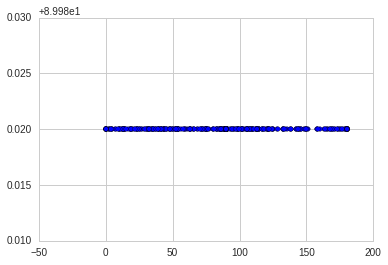

In [392]:
plt.scatter(get_cumulative_score(logDF),logDF[' Cumulative Score'])

In [412]:
logDF=config[np.any([config[' Stim Text']==' Focus',config[' Stim Text']==' Wander',config[' Stim Text']==' Rest',config[' Stim Text']==' Push Button'],axis=0)]
logDF[' Cumulative Score'] = get_cumulative_score(logDF,True)
signs= get_cumulative_score(logDF,False)
len(logDF)

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411

In [409]:
logDF

,Time Stamp,STIM,Left Text,Right Text,Stim Text,Show,Sign,Classifier Output,Detrended Output,Cumulative Score
3,4.035,STIM,Wandering,Focused,Rest,9999.0,1.0,221.714,221.714,90.000
5,6.019,STIM,Wandering,Focused,Rest,9999.0,1.0,222.029,222.029,90.000
7,8.019,STIM,Wandering,Focused,Rest,9999.0,1.0,221.592,221.592,90.000
9,10.019,STIM,Wandering,Focused,Rest,9999.0,1.0,220.456,220.456,90.000
11,12.019,STIM,Wandering,Focused,Rest,9999.0,1.0,0.071,0.071,90.000
13,14.018,STIM,Wandering,Focused,Rest,9999.0,1.0,0.192,0.192,90.000
15,16.018,STIM,Wandering,Focused,Rest,9999.0,1.0,0.350,0.350,90.000
17,18.018,STIM,Wandering,Focused,Rest,9999.0,1.0,0.341,0.341,90.000
19,20.002,STIM,Wandering,Focused,Rest,9999.0,1.0,0.200,0.200,90.000
21,22.035,STIM,Wandering,Focused,Rest,9999.0,1.0,-0.036,-0.036,90.000


In [454]:
reload(nipype)
from nipype.workflows.fmri.fsl import (create_featreg_preproc,
                                       create_modelfit_workflow,
                                       create_reg_workflow)
from nipype.interfaces.fsl.model import Level1Design

In [417]:
model=create_modelfit_workflow()

In [428]:
l1=model.get_node('level1design')

In [430]:
l1.inputs


bases = <undefined>
contrasts = <undefined>
ignore_exception = False
interscan_interval = <undefined>
model_serial_correlations = <undefined>
session_info = <undefined>

In [457]:
reload(Level1Design)
l2=Level1Design()

TypeError: reload() argument must be module

In [458]:
l2.inputs


bases = <undefined>
contrasts = <undefined>
ignore_exception = False
interscan_interval = <undefined>
model_serial_correlations = <undefined>
session_info = <undefined>

In [226]:
! pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org --upgrade nitime

[sudo] password for jmuraskin: 



In [ ]:
from nilearn import input_data
import os


folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ConjAnalysis/'
# folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/DMN_PC/cope0_age_gender/'


os.system('fslmaths %s/cluster_mask_cope3-cope4-zstat1-conj.nii.gz -bin %s/threshold_mask' % (folder,folder))

# Extracting signal from sphere around DMN seeds
masker = input_data.NiftiMasker(mask_img='%s/threshold_mask.nii.gz' % folder,
    mask_strategy='background',
    detrend=False, standardize=True, memory='nilearn_cache', 
    memory_level=1, verbose=2)


roi_coords = [(9,21,30)]
s_masker = NiftiSpheresMasker(roi_coords, radius=8,
                                         detrend=False, standardize=False, 
                                         memory='nilearn_cache', 
                                         memory_level=1)

# fb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
# nofb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
masker.fit()

columns=[]
for x in range(10):
    columns.append('RSN%d' % x)
count=0
group=[]
for subj in ['CCD016']:

    tmpSubj=pd.read_csv('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/spatial_map_timeseries_for_DR/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_spatial_map_PNAS_Smith09_rsn10/spatial_map_timeseries.txt'% (subj,scanorder.loc[subj]),delim_whitespace=True,names=columns)
    bold_signal = s_masker.fit_transform('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % (subj,scanorder.loc[subj]))


0.307793712152


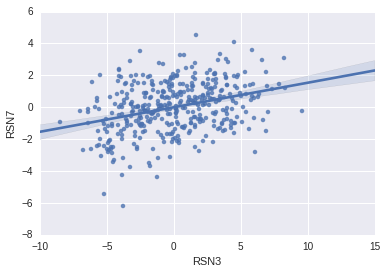

In [219]:
from scipy.stats import spearmanr
sns.regplot(x=tmpSubj['RSN3'],y=tmpSubj['RSN7'])

r,p = spearmanr(tmpSubj['RSN3'],tmpSubj['RSN7'])
print r

In [220]:
from statsmodels.tsa.stattools import grangercausalitytests

In [224]:
results=grangercausalitytests(np.column_stack((tmpSubj['RSN9'],tmpSubj['RSN3'])),8)


Granger Causality
('number of lags (no zero)', 1)
ssr based F test:         F=6.6453  , p=0.0103  , df_denom=404, df_num=1
ssr based chi2 test:   chi2=6.6947  , p=0.0097  , df=1
likelihood ratio test: chi2=6.6402  , p=0.0100  , df=1
parameter F test:         F=6.6453  , p=0.0103  , df_denom=404, df_num=1

Granger Causality
('number of lags (no zero)', 2)
ssr based F test:         F=3.2740  , p=0.0389  , df_denom=401, df_num=2
ssr based chi2 test:   chi2=6.6297  , p=0.0363  , df=2
likelihood ratio test: chi2=6.5762  , p=0.0373  , df=2
parameter F test:         F=3.2740  , p=0.0389  , df_denom=401, df_num=2

Granger Causality
('number of lags (no zero)', 3)
ssr based F test:         F=2.3205  , p=0.0748  , df_denom=398, df_num=3
ssr based chi2 test:   chi2=7.0839  , p=0.0693  , df=3
likelihood ratio test: chi2=7.0227  , p=0.0712  , df=3
parameter F test:         F=2.3205  , p=0.0748  , df_denom=398, df_num=3

Granger Causality
('number of lags (no zero)', 4)
ssr based F test:         F=

(408, 2142)